In [1]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs
import cython
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
%load_ext Cython

In [2]:
train_values_short = pd.read_csv('train_values_short.csv', index_col='building_id')

In [3]:
train_labels = pd.read_csv('train_labels.csv', index_col='building_id')

In [4]:
train_values = pd.read_csv('train_values.csv', index_col='building_id')
merged = train_labels.merge(train_values, right_index=True,
                            left_index=True)

# Feature Engenierg

In [3]:
train_values_short = train_values.copy(deep=True)
categoricas = ['foundation_type', 'roof_type', 'ground_floor_type',
        "other_floor_type", "plan_configuration", 
        "legal_ownership_status"]

# Usamos mean target encoding que despues va a servir para 
# las distancias
for col in categoricas:
        train_values_short[col] = merged[[col, 'damage_grade']]\
        .groupby(col).transform('mean')

In [19]:
train_values_short['geo_id'] = merged[['geo_level_1_id', 
    'geo_level_2_id', 'geo_level_3_id', 'damage_grade']]\
    .groupby(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'])\
    .transform('mean')

Hacemos lo mismo para el geo_level_id dado que en el analisis explorotorio vimos que no parecian estar ordenados (ej: el 17 no estaba al lado del 18) por lo que no tendria sentido restarlos. En cambio, se puede suponer una tendencia a que en el caso de regiones que hayan tenido en promedio daños similares, sus edificaciones se vieron afectadas de forma similar por encontrarse alli.

# KNN

### Distancias

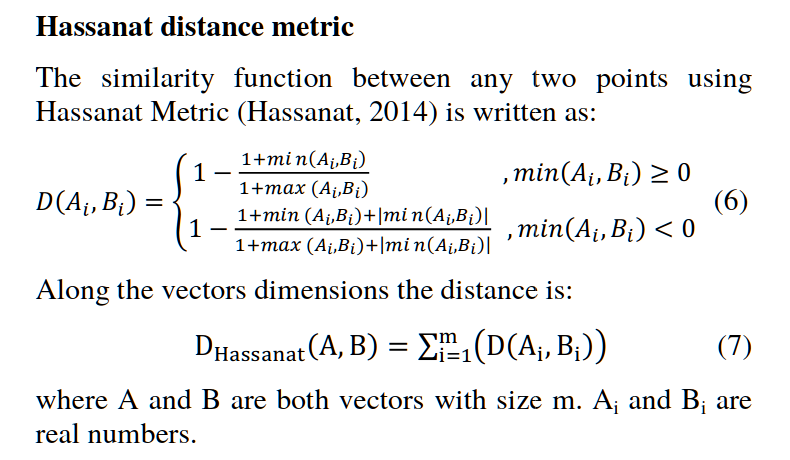

In [4]:
%%cython
def hassanat(double[:] x, double[:] y):
    cdef int n = x.shape[0]
    cdef double res = 0
    cdef double d, minimo, maximo
    
    for i in range(n):
        minimo = min(x[i],y[i])
        maximo = max(x[i],y[i])

        if (minimo >=0):
            d =  1 - ( (1+minimo)/(1+maximo) )
        else:
            d =  1 - ( (1+minimo+abs(minimo))/(1+maximo+abs(minimo)) )
        res += d
    
    return res

### Modelo

#### Optimizacion bayesiana

In [18]:
x_train, x_test, y_train, y_test = train_test_split(train_values_short,
                                train_labels, test_size=0.02) 

In [2]:
%%cython
def hassanat1(double[:] x, double[:] y, double[:] factores):
    cdef int n = x.shape[0]
    cdef double res = 0
    cdef double d, minimo, maximo

    for i in range(n):
        minimo = min(x[i],y[i])
        maximo = max(x[i],y[i])
        if (minimo >=0):
            d =  1 - ( (1+minimo)/(1+maximo) )
        else:
            d =  1 - ( (1+minimo+abs(minimo))/(1+maximo+abs(minimo)) )
        res += d * factores[i]
    
    return res

In [3]:
def funcion_a_optimizar(k, factor_superestructuras):
    k = round(k)
    # Nota: en el momento en el que se corrio esto las columnas
    # de las superestructuras estaban al principio
    factores = np.concatenate((np.repeat(factor_superestructuras,11),np.repeat(1,21)))
    knn = KNeighborsClassifier(weights="distance",n_neighbors=k,
                  metric=hassanat1, metric_params={'factores':factores})
    knn.fit(x_train, y_train.values.ravel())
    prediction = knn.predict(x_test)
    return f1_score(y_test, prediction, average='micro')

In [21]:
limites = {'k':(3,15), 'factor_superestructuras':(5,10)}

optimizer = BayesianOptimization(
    f=funcion_a_optimizar,
    pbounds=limites,
    random_state=1,
)

In [22]:
optimizer.maximize(
    init_points=2,
    n_iter=20,
)

|   iter    |  target   | factor... |     k     |
-------------------------------------------------
|  1        |  0.7209   |  7.085    |  11.64    |
|  2        |  0.7174   |  5.001    |  6.628    |
|  3        |  0.7209   |  7.218    |  11.5     |
|  4        |  0.7236   |  10.0     |  15.0     |
|  5        |  0.7228   |  10.0     |  13.17    |
|  6        |  0.7236   |  8.508    |  15.0     |
|  7        |  0.7232   |  5.0      |  15.0     |
|  8        |  0.7029   |  10.0     |  3.0      |
|  9        |  0.7236   |  6.73     |  14.98    |
|  10       |  0.7203   |  9.24     |  14.39    |
|  11       |  0.7194   |  10.0     |  9.775    |
|  12       |  0.7199   |  5.0      |  10.18    |
|  13       |  0.7027   |  5.0      |  3.0      |
|  14       |  0.7222   |  5.0      |  13.03    |


KeyboardInterrupt: 

# Feature engeniering II

Dado que la funcion de distancia es muy lenta, voy a hacer pruebas para ver si codificando las columnas booleanas con mean encoding anda mas rapido

In [8]:
x_train, x_test, y_train, y_test = train_test_split(train_values_short,
                                train_labels, test_size=0.0005)

In [130]:
# Lo corro como estaba antes
factores = np.concatenate((np.repeat(10,11),np.repeat(1,21))).astype('double')
knn = KNeighborsClassifier(weights="distance",n_neighbors=15,
metric=hassanat1, metric_params={'factores':factores})
knn.fit(x_train, y_train.values.ravel())
start = time.time()
prediction = knn.predict(x_test)
stop = time.time()
print(stop-start)
print(f1_score(y_test, prediction, average='micro'))

71.24405860900879
0.7938931297709924


In [5]:
secondary_uses =  ['has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
       'has_secondary_use_health_post', 'has_secondary_use_gov_office',
       'has_secondary_use_use_police', 'has_secondary_use_other']

superestructures = ['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other']

train_values_short['secondary_use'] = merged\
        .groupby(secondary_uses)\
        .damage_grade.transform('mean')
    

train_values_short['superestructure'] = merged\
    .groupby(superestructures).damage_grade.transform('mean')

    

In [11]:
x_train, x_test, y_train, y_test = train_test_split(train_values_short,
                                train_labels, test_size=0.0005)

In [12]:
factores = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10]).astype('double')
knn = KNeighborsClassifier(weights="distance",n_neighbors=15,
metric=hassanat1, metric_params={'factores':factores})
knn.fit(x_train, y_train.values.ravel())
start = time.time()
prediction = knn.predict(x_test)
stop = time.time()
print(stop-start)
print(f1_score(y_test, prediction, average='micro'))

29.418328046798706
0.7480916030534351


Como tardo la mitad y aparente la efectividad no cambio tanto voy a seguir con este

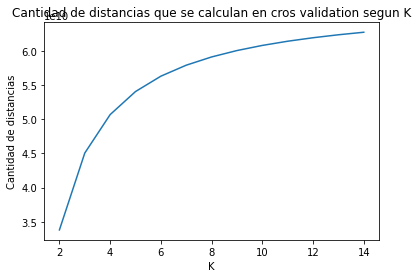

In [170]:
cant_distancias = []
for k in range(2,15):
    tamanio_folds = 260000/k
    cant_distancias.append(tamanio_folds * tamanio_folds * (k-1) *k)
    
plt.plot(range(2,15), cant_distancias)
plt.title('Cantidad de distancias que se calculan en cros validation segun K')
plt.xlabel('K')
plt.ylabel('Cantidad de distancias')
plt.show()

Calculo que usar cros validation con K=2 tardaria 8 horas, por lo que sigue siendo bastante

# Optimizacion bayesiana II

In [52]:
x_train, x_test, y_train, y_test = train_test_split(train_values_short,
                                train_labels, test_size=0.025)

In [53]:
# Tengo que adaptar al nuevo df
def funcion_a_optimizar1(k, factor_superestructuras):
    k = round(k)
    factores = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, factor_superestructuras]).astype('double')
    knn = KNeighborsClassifier(weights="distance",n_neighbors=k,
                  metric=hassanat1, metric_params={'factores':factores})
    knn.fit(x_train, y_train.values.ravel())
    prediction = knn.predict(x_test)
    return f1_score(y_test, prediction, average='micro')

In [60]:
limites = {'k':(15,30), 'factor_superestructuras':(6.5,15)}

optimizer = BayesianOptimization(
    f=funcion_a_optimizar1,
    pbounds=limites,
    random_state=4,
    bounds_transformer=SequentialDomainReductionTransformer()
)
load_logs(optimizer,logs=["./logs_anteriores.json"])
logger = JSONLogger(path="./logs_nuevos.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

In [63]:
optimizer.maximize(
    init_points=0,
    n_iter=1,
)

In [64]:
for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

Iteration 0: 
	{'target': 0.7203806015960712, 'params': {'factor_superestructuras': 10.205956668207032, 'k': 15.38889347741837}}
Iteration 1: 
	{'target': 0.7234499693063229, 'params': {'factor_superestructuras': 13.579324460707818, 'k': 21.069165674304887}}
Iteration 2: 
	{'target': 0.72268262737876, 'params': {'factor_superestructuras': 13.218268150316664, 'k': 21.814679516700252}}
Iteration 3: 
	{'target': 0.7213014119091468, 'params': {'factor_superestructuras': 15.0, 'k': 19.653942464209067}}
Iteration 4: 
	{'target': 0.7213014119091468, 'params': {'factor_superestructuras': 12.703433958548061, 'k': 20.46682835003278}}
Iteration 5: 
	{'target': 0.7234499693063229, 'params': {'factor_superestructuras': 13.996920645654875, 'k': 21.462493794118366}}
Iteration 6: 
	{'target': 0.72268262737876, 'params': {'factor_superestructuras': 14.944031358225788, 'k': 22.385708329657927}}
Iteration 7: 
	{'target': 0.7225291589932473, 'params': {'factor_superestructuras': 13.857708814026948, 'k': 2

In [68]:
optimizer.max

{'target': 0.7294352363413137,
 'params': {'factor_superestructuras': 14.318416163761984,
  'k': 20.827980819591588}}

# Submission I

In [3]:
test_values = pd.read_csv('test_values.csv', index_col='building_id')

In [4]:
# Hago los cambios que en las columnas que habia hecho antes pero para el set de test

def mean_encoding(df, cols, nombre_col):
    means = merged.groupby(cols).damage_grade.mean().reset_index()

    means [nombre_col] = means.apply(lambda x: '-'.join(x[cols].values.astype(int).astype(str)), axis="columns")   
    dic = means.set_index(nombre_col)['damage_grade'].to_dict()

    df_short = df.copy(deep=True)
    df_short[nombre_col] = df_short.apply(lambda x: '-'.join(x[cols].values.astype(int).astype(str)),
                                          axis="columns")
    df_short.replace({nombre_col:dic},inplace=True)
    
    return (df_short)

In [5]:
secondary_uses =  ['has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
       'has_secondary_use_health_post', 'has_secondary_use_gov_office',
       'has_secondary_use_use_police', 'has_secondary_use_other']

superestructures = ['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other']

geo_levels = ["geo_level_1_id", "geo_level_2_id", "geo_level_3_id"]

In [6]:
test_values_short = mean_encoding(test_values, superestructures, 'superestructure')

Dado que en el set de test hay combinaciones de los valores de superestructuras que no se encuentran en el set de entrenamiento, quedan valores que no se pueden representar, al menos directamente, con mean encoding. Aqui nos encontramos frente al problema de encontrar en el set de entrenamiento, superestructuras similares a las que pueden verse en el set de test. Dicho de otra forma, para estos casos nececitamos encontrar "las superestructuras mas cercanas", para sacar el mean encoding de ellas. Encontramos que la mejor solucion para esto es utilizar, nuevamente, KNN pero esta vez para una regresion. 

In [10]:
unfound_superestructures = test_values_short[test_values_short.superestructure.str.contains("-",na=False)]\
            .index.to_list()

supestructures_test = test_values.loc[unfound_superestructures, superestructures]

superestructures_train_values = train_values.loc[:,superestructures]

knn = KNeighborsRegressor(weights="distance",n_neighbors=3, metric='manhattan')
knn.fit(superestructures_train_values, train_values_short.superestructure.values.ravel())
prediction_superestructures = knn.predict(supestructures_test)

In [11]:
valores_anteriores = test_values_short.loc[unfound_superestructures, "superestructure"].values
dic={}
for i in range(len(prediction_superestructures)):
    dic[valores_anteriores[i]] = prediction_superestructures[i]

test_values_short.replace({'superestructure':dic}, inplace=True)

In [382]:
test_values_short = mean_encoding(test_values_short, geo_levels, 'geo_id')

In [383]:
# Hay combinaciones de geo_level_id que no estaban en el merged
# para esos casos voy a usar el promedio de los primeros 2 geo_level_id
unfound_geo = test_values_short[test_values_short.geo_id.str.contains("-",na=False)].index.to_list()

for i in unfound_geo:
    geo_id1 = test_values.loc[i].geo_level_1_id
    geo_id2 = test_values.loc[i].geo_level_2_id
    mean = merged.loc[(merged['geo_level_1_id']==geo_id1)&
               (merged['geo_level_2_id']==geo_id2),'damage_grade'].mean()

    test_values_short.loc[i,'geo_id'] = mean

In [395]:
# A los que no tenian ninguna combinacion para los dos primeros geo_ids les pongo el promedio de
# coinciderar solo el primero
for id in test_values_short[test_values_short.geo_id.isna() == True].index:
    geo_id1 = test_values.loc[id].geo_level_1_id
    mean = merged.loc[(merged['geo_level_1_id']==geo_id1),'damage_grade'].mean()

    test_values_short.loc[id,'geo_id'] = mean

In [12]:
test_values_short = mean_encoding(test_values_short, secondary_uses, 'secondary_use')

In [13]:
categoricas = ['foundation_type', 'roof_type', 'ground_floor_type', "other_floor_type",
              "plan_configuration", "legal_ownership_status"]

# Aca reemplazo por el promedio en el set de datos
for col in categoricas:
    dic = (merged[[col, 'damage_grade']].groupby(col).mean().to_dict()['damage_grade'])
    test_values_short.replace({col:dic},inplace=True)

In [390]:
# Ordenos las columnas como en otro
test_values_short = test_values_short[['geo_id', 'count_floors_pre_eq', 'age', 'height_percentage',
       'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type',
       'plan_configuration', 'legal_ownership_status', 'secondary_use',
       'superestructure']]

In [396]:
# Guardo el archivo para despues no tener que repteri todo esto
test_values_short.to_csv('test_values_short.csv', index=True)

In [397]:
start = time.time()
factores = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 14.318416163761984]).astype('double')
knn = KNeighborsClassifier(weights="distance",n_neighbors=21,
    metric=hassanat1, metric_params={'factores':factores})
knn.fit(train_values_short, train_labels.values.ravel())
prediction = knn.predict(test_values_short)
end = time.time()
print(round(end-start))

21229


In [408]:
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=prediction,
                             columns=submission_format.columns,
                             
                             index=submission_format.index)

In [410]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,3
745817,1
421793,3


In [411]:
my_submission.to_csv('submission.csv')

# Feature Engeniering III

In [7]:
def intervalo_de_confianza(data):
    std = np.std(data)
    # Pongo arbitriamente ese valor ya que sino la funcion devuelve 
    # nan para esos casos
    # elijo ese valor para que cuanto mas se repita el mismo valor mas
    #chico de el intervalo de confianza
    if (std == 0):
        std = 1/len(data) 

    if (len(data)>=30):
        return st.norm.interval(alpha=0.95, 
            loc=np.mean(data), scale=std)
    else:
        # pongo 1 ocmo minimo en df para que no devuleva nan
        return st.t.interval(alpha=0.95, df=max(len(data)-1,1),
                 loc=np.mean(data), scale=std)     

In [8]:
# devuelvo el limiete inferior del intervalo
def min_ic(data):
    return intervalo_de_confianza(data)[0]

def max_ic(data):
    return intervalo_de_confianza(data)[1]

In [9]:
train_values_short ['min_geo_id'] = merged.groupby(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'])\
                                                    ['damage_grade'].transform(min_ic)
train_values_short ['max_geo_id'] = merged.groupby(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'])\
                                                    ['damage_grade'].transform(max_ic)

In [10]:
columnas = ["count_floors_pre_eq", "age", "area_percentage", "height_percentage", 
   "foundation_type", "roof_type", "ground_floor_type", "other_floor_type",                                
   "plan_configuration", "legal_ownership_status", "secondary_use", 'min_geo_id', 'max_geo_id', "superestructure"]
train_values_short = train_values_short[columnas]

Ahora pruebo si con esto cambios el modelo predice mejor

In [21]:
columnas = ["count_floors_pre_eq", "age", "area_percentage", "height_percentage", 
   "foundation_type", "roof_type", "ground_floor_type", "other_floor_type",                                
   "plan_configuration", "legal_ownership_status", "secondary_use", 'geo_id', "superestructure"]
train_values_short = train_values_short[columnas]

In [23]:
x_train, x_test, y_train, y_test = train_test_split(train_values_short,
                                train_labels, test_size=0.025)

In [24]:
# Primero pruebo como estaba antes
start = time.time()
factores = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 14.318416163761984]).astype('double')
knn = KNeighborsClassifier(weights="distance",n_neighbors=21,
    metric=hassanat1, metric_params={'factores':factores})
knn.fit(x_train, y_train.values.ravel())
start = time.time()
prediction = knn.predict(x_test)
stop = time.time()
print(stop-start)
print(f1_score(y_test, prediction, average='micro'))

2238.9976892471313
0.720073664825046


In [38]:
# Ahora train_values_short tiene los nuevos cambios
x_train1 = x_train.index.to_frame().merge(train_values_short, left_index=True, right_index=True)\
            .drop(columns='building_id')
x_test1 = x_test.index.to_frame().merge(train_values_short, left_index=True, right_index=True)\
            .drop(columns='building_id')

In [39]:
start = time.time()
factores = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 14.318416163761984]).astype('double')
knn = KNeighborsClassifier(weights="distance",n_neighbors=21,
    metric=hassanat1, metric_params={'factores':factores})
knn.fit(x_train1, y_train.values.ravel())
start = time.time()
prediction = knn.predict(x_test1)
stop = time.time()
print(stop-start)
print(f1_score(y_test, prediction, average='micro'))

2359.0229268074036
0.7364947820748926


Dio mucho mejor con el intervalo de confianza, por lo que se continuara utilizando

# Optimizacion bayesiana III

### Busco el factor del geo id

In [12]:
x_train, x_test, y_train, y_test = train_test_split(train_values_short,
                                train_labels, test_size=0.023, random_state=2)

In [6]:
# Tengo que adaptar al nuevo df
def funcion_a_optimizar1(k, factor_superestructuras, factor_geo_id):
    k = round(k)
    factores = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                         factor_geo_id,  factor_geo_id, factor_superestructuras]).astype('double')
    knn = KNeighborsClassifier(weights="distance",n_neighbors=k,
                  metric=hassanat1, metric_params={'factores':factores})
    knn.fit(x_train, y_train.values.ravel())
    prediction = knn.predict(x_test)
    return f1_score(y_test, prediction, average='micro')

In [ ]:
limites = {'k':(20,22), 'factor_superestructuras':(14,17), 'factor_geo_id':(3,8)}

optimizer = BayesianOptimization(
    f=funcion_a_optimizar1,
    pbounds=limites,
    random_state=5,
    bounds_transformer=SequentialDomainReductionTransformer()
)
load_logs(optimizer,logs=["./logs_anteriores.json"])
logger = JSONLogger(path="./logs_nuevos.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

In [45]:
optimizer.maximize(
    init_points=5,
    n_iter=10,
)

In [24]:
def target(resultado):
    return resultado['target']

def mostrar(resultados, keys, min=0):
    
    print( "i", end = '\t\t') 
    print("target", end = '\t\t') 
    for key in keys:
        print(  key, end = '\t') 
    print()
    
    a_borrar = []
    for resultado in resultados:
        if(resultado['target']<min):
            a_borrar.append(resultado)
    resultados_importantes = [a for a in resultados if a not in a_borrar]
    
    resultados_importantes.sort(reverse=True, key=target)
    
    for i, res in enumerate(resultados_importantes):
        cells = []

        cells.append(i)
        cells.append(res["target"])

        for key in keys:
            cells.append(res["params"][key])
        
        for j in cells:
            print("| " + str(j), end = '\t') 
            
        print()

In [16]:
mostrar(optimizer.res, ['k', 'factor_superestructuras', 'factor_geo_id'])

i		target			k		factor_superestructuras		factor_geo_id		
| 0	| 0.7343180510262804	| 20.413438310678853	| 16.612196918532128	| 4.1099658554486975	
| 1	| 0.7356608478802993	| 21.223487725805292	| 15.465233566384487	| 7.593054539689608	
| 2	| 0.7356608478802993	| 20.593601003152443	| 15.55525396361883	| 6.829539282401578	
| 3	| 0.7314406291962402	| 21.47688059239794	| 14.242223806294625	| 3.938606143306258	
| 4	| 0.7335507385382697	| 21.75987406240256	| 14.474929603137953	| 5.206546114479766	
| 5	| 0.735277191636294	| 21.63331734435643	| 16.070875044487384	| 6.836548921521129	
| 6	| 0.735277191636294	| 20.854641069109267	| 16.010310896677094	| 8.0	
| 7	| 0.735852676002302	| 20.89152573477887	| 14.97466396912114	| 8.0	
| 8	| 0.7350853635142912	| 20.60935804240641	| 14.557679811447295	| 7.4688546773706985	
| 9	| 0.7360445041243047	| 21.145476657914084	| 14.59937822721468	| 8.0	
| 10	| 0.73642816036831	| 21.361334942579017	| 14.91837110783517	| 8.0	
| 11	| 0.7356608478802993	| 21.577193227243

### Busco el factor del porcentaje de area

In [6]:
x_train, x_test, y_train, y_test = train_test_split(train_values_short,
                                train_labels, test_size=0.022, random_state=11)

In [11]:
# Tengo que adaptar al nuevo df
def funcion_a_optimizar2(factor_area, factor_superestructuras, factor_geo_id):
    k = 22
    factores = np.array([1, 1, factor_area, 1, 1, 1, 1, 1, 1, 1, 1,
                         factor_geo_id,  factor_geo_id, factor_superestructuras]).astype('double')
    knn = KNeighborsClassifier(weights="distance",n_neighbors=k,
                  metric=hassanat1, metric_params={'factores':factores})
    knn.fit(x_train, y_train.values.ravel())
    prediction = knn.predict(x_test)
    return f1_score(y_test, prediction, average='micro')

In [24]:
limites = {"factor_geo_id": (7, 8), "factor_superestructuras":(14,15), 'factor_area':(0,1)}

optimizer = BayesianOptimization(
    f=funcion_a_optimizar2,
    pbounds=limites,
    random_state=6,
    bounds_transformer=SequentialDomainReductionTransformer(),
    verbose=5
)
logger = JSONLogger(path="./logs_nuevos.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

In [ ]:
optimizer.maximize( init_points=1,n_iter=10)

In [36]:
optimizer.probe(
    params={"factor_geo_id": 7.551775435267911 , "factor_superestructuras":14, 'factor_area':0},
    lazy=True,
)

In [37]:
optimizer.probe(
    params={"factor_geo_id": 7.551775435267911 , "factor_superestructuras":14, 'factor_area':1},
    lazy=True,
)

In [44]:
mostrar(optimizer.res, ['factor_geo_id', 'factor_superestructuras','factor_area'])

i		target		factor_geo_id	factor_superestructuras	factor_area	
| 0	| 0.7312521799790722	| 7.331979805301177	| 14.821229123057831	| 0.8928601514360016	
| 1	| 0.7347401464945936	| 7.7098706297636275	| 14.447938493249744	| 0.5172531893540486	
| 2	| 0.7319497732821765	| 7.551775435267911	| 14.0	| 0.1	
| 3	| 0.7227066620160446	| 7.551775435267911	| 14.0	| 0.0	
| 4	| 0.7335193582141611	| 7.551775435267911	| 14.0	| 1.0	
| 5	| 0.735437739797698	| 7.469622929520041	| 14.502124453610646	| 0.26420690315364237	
| 6	| 0.7349145448203698	| 7.654559846534497	| 14.354110086371174	| 0.5337164606077807	
| 7	| 0.7373561213812347	| 7.508261370013642	| 14.483312165426854	| 0.3139710742344524	
| 8	| 0.7368329264039065	| 7.560645835154705	| 14.494324446277133	| 0.3160068223680391	
| 9	| 0.7335193582141611	| 7.529329329149832	| 14.422878743656192	| 0.42134660329248863	
| 10	| 0.7361353331008023	| 7.421656976733248	| 14.578159416527404	| 0.27012408389841996	
| 11	| 0.7370073247296826	| 7.502489447083382	| 14.41

In [45]:
optimizer.max

{'target': 0.7373561213812347,
 'params': {'factor_area': 0.3139710742344524,
  'factor_geo_id': 7.508261370013642,
  'factor_superestructuras': 14.483312165426854}}

In [49]:
# Pruebo los parametros que mejor funcionarion aca y en la etapa anterior con otros datos
x_train, x_test, y_train, y_test = train_test_split(train_values_short,
                                train_labels, test_size=0.022, random_state=6)

In [14]:
funcion_a_optimizar2(0.31, 14.48, 7.5)

0.7401464945936519

In [15]:
funcion_a_optimizar2(0.31, 14, 7.5)

0.7397976979420996

In [16]:
# Pruebo que pasaria con K=21
def funcion_a_optimizar2_y_medio(factor_area, factor_superestructuras, factor_geo_id):
    k = 21
    factores = np.array([1, 1, factor_area, 1, 1, 1, 1, 1, 1, 1, 1,
                         factor_geo_id,  factor_geo_id, factor_superestructuras]).astype('double')
    knn = KNeighborsClassifier(weights="distance",n_neighbors=k,
                  metric=hassanat1, metric_params={'factores':factores})
    knn.fit(x_train, y_train.values.ravel())
    prediction = knn.predict(x_test)
    return f1_score(y_test, prediction, average='micro')

In [17]:
funcion_a_optimizar2_y_medio(0.31, 14.48, 7.5)

0.738053714684339

In [8]:
def funcion_a_optimizar3(factor_legal_ownership_status, factor_secondary_use):
    factor_area = 0.3139710742344524
    factor_superestructuras = 14.483312165426854
    factor_geo_id = 7.508261370013642
    k = 22
    factores = np.array([1, 1, factor_area, 1, 1, 1, 1, 1, 1, factor_legal_ownership_status, factor_secondary_use,
                         factor_geo_id,  factor_geo_id, factor_superestructuras]).astype('double')
    knn = KNeighborsClassifier(weights="distance",n_neighbors=k,
                  metric=hassanat1, metric_params={'factores':factores})
    knn.fit(x_train, y_train.values.ravel())
    prediction = knn.predict(x_test)
    return f1_score(y_test, prediction, average='micro')

In [9]:
limites = {"factor_legal_ownership_status":(0,1), "factor_secondary_use":(0,1)}

optimizer = BayesianOptimization(
    f=funcion_a_optimizar3,
    pbounds=limites,
    random_state=7,
    bounds_transformer=SequentialDomainReductionTransformer(),
    verbose=5
)
load_logs(optimizer,"./logs_anteriores.json" )
logger = JSONLogger(path="./logs_nuevos.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

In [ ]:
optimizer.maximize( init_points=3,n_iter=11)

In [29]:
optimizer.probe(
    params={"factor_legal_ownership_status":0, "factor_secondary_use":0},
    lazy=False,
)

In [27]:
optimizer.probe(
    params={"factor_legal_ownership_status":0.3, "factor_secondary_use":0.3},
    lazy=False,
)

In [28]:
optimizer.probe(
    params={"factor_legal_ownership_status":1, "factor_secondary_use":1},
    lazy=False,
)

In [14]:
optimizer.probe(
    params={"factor_legal_ownership_status":0.3, "factor_secondary_use":0},
    lazy=False,
)

In [ ]:
optimizer.probe(
    params={"factor_legal_ownership_status":0, "factor_secondary_use":0.3},
    lazy=False,
)

In [10]:
mostrar(optimizer.res, ["factor_legal_ownership_status", "factor_secondary_use"])

i		target		factor_legal_ownership_status	factor_secondary_use	
| 0	| 0.7401464945936519	| 0.07630828937395717	| 0.7799187922401146	
| 1	| 0.7392745029647715	| 0.460123703842655	| 0.3889147318521204	
| 2	| 0.7396232996163237	| 0.3	| 0.0	
| 3	| 0.7397976979420996	| 0.3	| 0.3	
| 4	| 0.7399720962678759	| 0.0	| 0.3	
| 5	| 0.7392745029647715	| 0.3158199121776555	| 0.7854780629224765	
| 6	| 0.7403208929194279	| 0.12558762490941516	| 0.7726106929827516	
| 7	| 0.7399720962678759	| 0.11987356200049168	| 0.6960149467285759	
| 8	| 0.7396232996163237	| 0.3781174737069006	| 0.5615195329148577	
| 9	| 0.7397976979420996	| 0.0	| 0.7726106929827516	


In [5]:
def funcion_a_optimizar4(factor_count_floors, factor_age, factor_foundation_type):
    factor_area = 0.3139710742344524
    factor_superestructuras = 14.483312165426854
    factor_geo_id = 7.508261370013642
    factor_legal_ownership_status = 0.12558762490941516
    factor_secondary_use = 0.7726106929827516
    k = 22
    factores = np.array([factor_count_floors, factor_age, factor_area, 1, factor_foundation_type,
                         1, 1, 1, 1, factor_legal_ownership_status, factor_secondary_use,
                         factor_geo_id,  factor_geo_id, factor_superestructuras]).astype('double')
    knn = KNeighborsClassifier(weights="distance",n_neighbors=k,
                  metric=hassanat1, metric_params={'factores':factores})
    knn.fit(x_train, y_train.values.ravel())
    prediction = knn.predict(x_test)
    return f1_score(y_test, prediction, average='micro')

In [26]:
limites = {"factor_count_floors":(1,3.5), "factor_age":(1,3.5), "factor_foundation_type":(1,3.5)}

optimizer = BayesianOptimization(
    f=funcion_a_optimizar4,
    pbounds=limites,
    random_state=9,
    bounds_transformer=SequentialDomainReductionTransformer(),
    verbose=5
)
load_logs(optimizer,"./logs_anteriores.json" )
logger = JSONLogger(path="./logs_nuevos.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

In [27]:
mostrar(optimizer.res, ['factor_age', "factor_count_floors", "factor_foundation_type"])

i		target		factor_age	factor_count_floors	factor_foundation_type	
| 0	| 0.7373561213812347	| 1.4284474180275466	| 2.5880526132171657	| 2.50292383616565	
| 1	| 0.7371817230554587	| 1.448691595036006	| 2.6111369672653244	| 2.4883988119221847	
| 2	| 0.7370073247296826	| 1.4235627772907133	| 2.546982936035466	| 2.6825600205806275	
| 3	| 0.7366585280781304	| 1.8097669015879276	| 2.98756547018097	| 3.0340135591560617	
| 4	| 0.7366585280781304	| 1.4672164495606745	| 2.3854275251989514	| 2.485290271102103	
| 5	| 0.7357865364492501	| 1.037773102485822	| 2.2587668134180627	| 2.211047764555282	
| 6	| 0.7356121381234739	| 1.0259353847142498	| 2.2546864803718467	| 2.239433232835365	
| 7	| 0.7356121381234739	| 1.3345738223981916	| 1.3552777136363463	| 1.5463966890651957	
| 8	| 0.7356121381234739	| 1.5233736239825275	| 2.5341415083284016	| 2.5714674619412436	
| 9	| 0.735437739797698	| 1.8637466001260004	| 1.4169408663308036	| 3.1963977138316477	
| 10	| 0.7352633414719218	| 1.23748121267569	| 2.631020

In [ ]:
optimizer.maximize( init_points=4,n_iter=10)

In [50]:
optimizer.probe(
    params={"factor_count_floors":1.9195786742228238, "factor_age":1, "factor_foundation_type":2.199668387926665},
    lazy=False,
)

In [51]:
optimizer.res[-1]
# Los parametros encontrados con el otro calor funcionan mejor aca que los que encontraron con este.
# Por lo tanto, son mejores

{'target': 0.7389257063132194,
 'params': {'factor_age': 1.0,
  'factor_count_floors': 1.9195786742228238,
  'factor_foundation_type': 2.199668387926665}}

Usando random_state del split 7
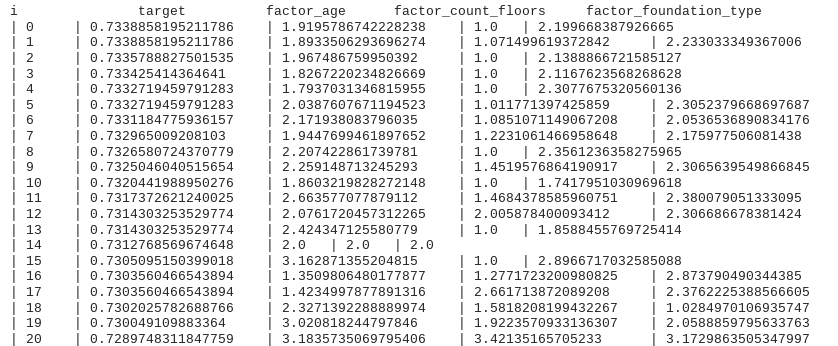

In [ ]:
# En cambio al reves esto no ocurre
{"target": 0.731123388581952, "params": {"factor_age": 2.5880526132171657, 
                                         "factor_count_floors": 1.4284474180275466,
                                         "factor_foundation_type": 2.50292383616565}, }}

In [62]:
def funcion_a_optimizar5(factor_age, factor_altura, factor_plan):
    factor_count_floors = 1.9195786742228238
    factor_area = 0.3139710742344524
    factor_foundation_type = 2.199668387926665
    factor_legal_ownership_status = 0.12558762490941516
    factor_secondary_use = 0.7726106929827516
    factor_geo_id = 7.508261370013642
    factor_superestructuras = 14.483312165426854
    
    k = 22
    factores = np.array([factor_count_floors, factor_age, factor_area, factor_altura, factor_foundation_type,
                         1, 1, 1, 1, factor_plan, factor_legal_ownership_status, factor_secondary_use,
                         factor_geo_id,  factor_geo_id, factor_superestructuras]).astype('double')
    knn = KNeighborsClassifier(weights="distance",n_neighbors=k,
                  metric=hassanat1, metric_params={'factores':factores})
    knn.fit(x_train, y_train.values.ravel())
    prediction = knn.predict(x_test)
    return f1_score(y_test, prediction, average='micro')

In [ ]:
limites = {"factor_age":(0,1), "factor_altura":(0.5,3), "factor_plan":(1,3.5)}

optimizer = BayesianOptimization(
    f=funcion_a_optimizar4,
    pbounds=limites,
    random_state=9,
    bounds_transformer=SequentialDomainReductionTransformer(),
    verbose=5
)
logger = JSONLogger(path="./logs_nuevos.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

## Todas las columnas

In [4]:
# Me quedo con los parametros, los promedios del target y la cantidad de veces que
# se usaron esos parametros
# Devuellve una lista en la que cada elemento es una lista con formato:
# [parametros_usados, promedio_target, cantidad]
def unificar_logs(listas_resultados):
    lista = []
    
    for res in listas_resultados:
        for i in res:
            los_parametros_no_estaban = True
            for j in lista:
                if (j[0]==i['params']):
                    total_anterior = j[1] * j[2]
                    j[2] += 1
                    j[1] = (total_anterior + i['target']) / j[2]                    
                    los_parametros_no_estaban = False
            if los_parametros_no_estaban:
                lista.append([i['params'],i['target'],1])
        
    return (lista)

In [5]:
def target_promedio(resultado):
    return resultado[1]

def mostrar_unificado(resultados, min_target=0, min_cantidad=2):
    
    resultados_unificados = unificar_logs(resultados)
    
    a_borrar = []
    for resultado in resultados_unificados:
        if(resultado[1]<min_target or resultado[2]<min_cantidad):
            a_borrar.append(resultado)
    resultados_importantes = [a for a in resultados_unificados if a not in a_borrar]
    
    resultados_importantes.sort(key=target_promedio, reverse=True)
    
    for resultado in resultados_importantes:
        print("target promedio: " , resultado[1])
        print("cantidad en los que se probo: " , resultado[2])
        print()
        for key,value in resultado[0].items():
            print("\t\t", key, ':', value)
        print()
        print()

In [7]:
def funcion_a_optimizar(count_floors, age, area, height,
       foundation, roof, ground_floor, other_floor,
       plan_configuration, legal_ownership, secondary_use,
       geo, superestructure):
    
    k = 22
    factores = np.array([count_floors, age, area, height,
       foundation, roof, ground_floor, other_floor,
       plan_configuration, legal_ownership, secondary_use,
       geo, geo, superestructure]).astype('double')
    knn = KNeighborsClassifier(weights="distance",n_neighbors=k,
                  metric=hassanat1, metric_params={'factores':factores})
    knn.fit(x_train, y_train.values.ravel())
    prediction = knn.predict(x_test)
    return f1_score(y_test, prediction, average='micro')

In [8]:
limites = {
"count_floors":(1.8,2),
"age":(0.1,0.2),
"area":(0.2,0.4),
"height":(0.4,0.6),
"foundation":(2.2,2.4),
"roof":(0.8,1.2),
"ground_floor":(0.8,1.2),
"other_floor":(0.8,1.2),
"plan_configuration":(1,3.5),
"legal_ownership":(0.1,3.4),
"secondary_use":(0.1, 0.8),
"geo":(3.8, 7.6),
"superestructure":(7.5,14.5),
}

In [9]:
optimizer1 = BayesianOptimization(
    f=funcion_a_optimizar,
    random_state=534634,
    bounds_transformer=SequentialDomainReductionTransformer(),
    verbose=5,
    pbounds=limites,
)
load_logs(optimizer1, "./logs/anteriores_534634.json")

In [10]:
optimizer2 = BayesianOptimization(
    f=funcion_a_optimizar,
    random_state=64656756,
    bounds_transformer=SequentialDomainReductionTransformer(),
    verbose=5,
    pbounds=limites,
)
load_logs(optimizer2, "./logs/anteriores_64656756.json")

In [11]:
optimizer3 = BayesianOptimization(
    f=funcion_a_optimizar,
    random_state=96069394,
    bounds_transformer=SequentialDomainReductionTransformer(),
    verbose=5,
    pbounds=limites,
)
load_logs(optimizer3, "./logs/anteriores_96069394.json")

In [12]:
optimizer4 = BayesianOptimization(
    f=funcion_a_optimizar,
    random_state=583848585,
    bounds_transformer=SequentialDomainReductionTransformer(),
    verbose=5,
    pbounds=limites,
)
load_logs(optimizer4, "./logs/anteriores_583848585.json")

In [100]:
mostrar_unificado([optimizer1.res, optimizer2.res, optimizer3.res, optimizer4.res])

target promedio:  0.7369228801637038
cantidad en los que se probo:  4

		 age : 0.1331076390865485
		 area : 0.3139710742344524
		 count_floors : 1.9195786742228238
		 foundation : 2.199668387926665
		 geo : 3.816924497
		 ground_floor : 1.0
		 height : 0.5186702671250013
		 legal_ownership : 3.3974077335766553
		 other_floor : 1.0
		 plan_configuration : 1.0
		 roof : 1.0
		 secondary_use : 0.12558762490941516
		 superestructure : 7.508261370013642


target promedio:  0.7358038112290575
cantidad en los que se probo:  4

		 age : 0.1331076390865485
		 area : 0.3139710742344524
		 count_floors : 1.9195786742228238
		 foundation : 2.199668387926665
		 geo : 7.508261370013642
		 ground_floor : 1.0
		 height : 0.5186702671250013
		 legal_ownership : 0.12558762490941516
		 other_floor : 1.0
		 plan_configuration : 3.3974077335766553
		 roof : 1.0
		 secondary_use : 0.7726106929827516
		 superestructure : 14.483312165426854


target promedio:  0.7357078910346592
cantidad en los que se probo:

In [101]:
# Combiando las soluciones que mejor funcionaron, aromo nuevas cosas para probar
prueba1 ={
    "age" : 0.1331076390865485,
    "area" : 0.3139710742344524,
    "count_floors" : 1.9195786742228238,
    "foundation" : 2.199668387926665,
    "geo" : 7.508261370013642,
    "ground_floor" : 1.0,
    "height" : 0.5186702671250013,
    "legal_ownership" : 3.3974077335766553,
    "other_floor" : 1.0,
    "plan_configuration" : 1.0,
    "roof" : 1.0,
    "secondary_use" : 0.12558762490941516,
    "superestructure" : 7.508261370013642
}

prueba2 ={
    "age" : 0.1331076390865485,
    "area" : 0.3139710742344524,
    "count_floors" : 1.9195786742228238,
    "foundation" : 2.199668387926665,
    "geo" : 3.816924497,
    "ground_floor" : 1.0,
    "height" : 0.5186702671250013,
    "legal_ownership" : 0.12558762490941516,
    "other_floor" : 1.0,
    "plan_configuration" : 1.0,
    "roof" : 1.0,
    "secondary_use" : 0.12558762490941516,
    "superestructure" : 7.508261370013642
}

prueba3 ={
    "age" : 0.1331076390865485,
    "area" : 0.3139710742344524,
    "count_floors" : 1.9195786742228238,
    "foundation" : 2.199668387926665,
    "geo" : 3.816924497,
    "ground_floor" : 1.0,
    "height" : 0.5186702671250013,
    "legal_ownership" : 3.3974077335766553,
    "other_floor" : 1.0,
    "plan_configuration" : 3.3974077335766553,
    "roof" : 1.0,
    "secondary_use" : 0.12558762490941516,
    "superestructure" : 7.508261370013642
}

prueba4 ={
    "age" : 0.1331076390865485,
    "area" : 0.3139710742344524,
    "count_floors" : 1.9195786742228238,
    "foundation" : 2.199668387926665,
    "geo" : 3.816924497,
    "ground_floor" : 1.0,
    "height" : 0.5186702671250013,
    "legal_ownership" : 3.3974077335766553,
    "other_floor" : 1.0,
    "plan_configuration" : 1.0,
    "roof" : 1.0,
    "secondary_use" : 0.7726106929827516,
    "superestructure" : 7.508261370013642
}

prueba5 ={
    "age" : 0.1331076390865485,
    "area" : 0.3139710742344524,
    "count_floors" : 1.9195786742228238,
    "foundation" : 2.199668387926665,
    "geo" : 3.816924497,
    "ground_floor" : 1.0,
    "height" : 0.5186702671250013,
    "legal_ownership" : 3.3974077335766553,
    "other_floor" : 1.0,
    "plan_configuration" : 1.0,
    "roof" : 1.0,
    "secondary_use" : 0.12558762490941516,
    "superestructure" : 14.483312165426854
}

In [13]:
mostrar_unificado([optimizer1.res, optimizer2.res, optimizer3.res, optimizer4.res])

target promedio:  0.7370507737562348
cantidad en los que se probo:  4

		 age : 0.1331076390865485
		 area : 0.3139710742344524
		 count_floors : 1.9195786742228238
		 foundation : 2.199668387926665
		 geo : 3.816924497
		 ground_floor : 1.0
		 height : 0.5186702671250013
		 legal_ownership : 0.12558762490941516
		 other_floor : 1.0
		 plan_configuration : 1.0
		 roof : 1.0
		 secondary_use : 0.12558762490941516
		 superestructure : 7.508261370013642


target promedio:  0.7369228801637039
cantidad en los que se probo:  3

		 age : 0.1331076390865485
		 area : 0.3139710742344524
		 count_floors : 1.9195786742228238
		 foundation : 2.199668387926665
		 geo : 3.816924497
		 ground_floor : 1.0
		 height : 0.5186702671250013
		 legal_ownership : 3.3974077335766553
		 other_floor : 1.0
		 plan_configuration : 1.0
		 roof : 1.0
		 secondary_use : 0.7726106929827516
		 superestructure : 7.508261370013642


target promedio:  0.7369228801637038
cantidad en los que se probo:  4

		 age : 0.133107

Conclusiones de esto:
- Los valores de geo=3.816924497, superestructure=7.508261370013642 y plan_configuration=1 funcionaron en todos los casos mucho mejor que los otros que se probaron para esas variables, por lo que se buscara en torno a esos valores
- Los distitnos valores de legal_ownership y secondary_use que se probaron tendieron a tener resultados bastante parecidos

In [10]:
optimizers = []
random_states = [534634, 64656756, 96069394,583848585]

for random_state in random_states:
    optimizer = BayesianOptimization(
        f=funcion_a_optimizar,
        random_state=random_state,
        bounds_transformer=SequentialDomainReductionTransformer(),
        verbose=5,
        pbounds=limites,
    )
    load_logs(optimizer, "./logs/1/anteriores_" + str(random_state) + ".json")
    optimizers.append(optimizer)

In [11]:
for i in optimizers:
    print(i.max)

{'target': 0.737946028903952, 'params': {'age': 0.14128377732965816, 'area': 0.2799959501449869, 'count_floors': 1.8226475583975548, 'foundation': 2.3088314135377765, 'geo': 4.9384514372525805, 'ground_floor': 1.079668066583942, 'height': 0.4755266040893181, 'legal_ownership': 0.8073630462515913, 'other_floor': 1.102921287156727, 'plan_configuration': 0.8381115917909457, 'roof': 1.0299612225224017, 'secondary_use': 0.7424368142997112, 'superestructure': 7.766396144779752}}
{'target': 0.7376902417188899, 'params': {'age': 0.1755125397831892, 'area': 0.2285432235080944, 'count_floors': 1.9542219918755623, 'foundation': 2.2853489214610865, 'geo': 3.8310439130401317, 'ground_floor': 0.9356487986441364, 'height': 0.5561534233105337, 'legal_ownership': 0.1715225258276129, 'other_floor': 1.0414287336517714, 'plan_configuration': 0.8826305849374843, 'roof': 0.9406104098232999, 'secondary_use': 0.6730026317513239, 'superestructure': 7.982505040752606}}
{'target': 0.7419107302724133, 'params': {

In [12]:
resultados = []
for i in optimizers:
    resultados.append(i.res)
    
mostrar_unificado(resultados)

target promedio:  0.7380419490983502
cantidad en los que se probo:  4

		 age : 0.14128377732965816
		 area : 0.2799959501449869
		 count_floors : 1.8226475583975548
		 foundation : 2.3088314135377765
		 geo : 4.9384514372525805
		 ground_floor : 1.079668066583942
		 height : 0.4755266040893181
		 legal_ownership : 0.8073630462515913
		 other_floor : 1.102921287156727
		 plan_configuration : 0.8381115917909457
		 roof : 1.0299612225224017
		 secondary_use : 0.7424368142997112
		 superestructure : 7.766396144779752


target promedio:  0.7375623481263589
cantidad en los que se probo:  4

		 age : 0.15027854886517117
		 area : 0.32079888936232925
		 count_floors : 1.991928892829264
		 foundation : 2.264837625060071
		 geo : 4.3293259627622955
		 ground_floor : 1.192925413447786
		 height : 0.586343367738843
		 legal_ownership : 0.7476303595681003
		 other_floor : 1.0929582287689625
		 plan_configuration : 1.111765378331604
		 roof : 1.116911232331278
		 secondary_use : 0.6053106267652771


In [15]:
# Los parametros que mejor funcionaron fueron:
parametros = {'age': 0.14128377732965816, 'area': 0.2799959501449869, 'count_floors': 1.8226475583975548, 'foundation': 2.3088314135377765, 'geo': 4.9384514372525805, 'ground_floor': 1.079668066583942, 'height': 0.4755266040893181, 'legal_ownership': 0.8073630462515913, 'other_floor': 1.102921287156727, 'plan_configuration': 0.8381115917909457, 'roof': 1.0299612225224017, 'secondary_use': 0.7424368142997112, 'superestructure': 7.766396144779752}
parametros

{'age': 0.14128377732965816,
 'area': 0.2799959501449869,
 'count_floors': 1.8226475583975548,
 'foundation': 2.3088314135377765,
 'geo': 4.9384514372525805,
 'ground_floor': 1.079668066583942,
 'height': 0.4755266040893181,
 'legal_ownership': 0.8073630462515913,
 'other_floor': 1.102921287156727,
 'plan_configuration': 0.8381115917909457,
 'roof': 1.0299612225224017,
 'secondary_use': 0.7424368142997112,
 'superestructure': 7.766396144779752}

In [14]:
columnas = ["count_floors", "age", "area", "height", 
   "foundation", "roof", "ground_floor", "other_floor",                                
   "plan_configuration", "legal_ownership", "secondary_use", 'geo', 'geo', "superestructure"]

In [28]:
lista = []
for col in columnas:
    lista.append(parametros[col])

factores = np.array(lista).astype('double')
factores

array([1.82264756, 0.14128378, 0.27999595, 0.4755266 , 2.30883141,
       1.02996122, 1.07966807, 1.10292129, 0.83811159, 0.80736305,
       0.74243681, 4.93845144, 4.93845144, 7.76639614])

# Feature engeniering (del set de test)

Agrego los cambios en el geo_id para el set de test

In [16]:
geo_levels = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
ic = merged.groupby(geo_levels).damage_grade.agg([min_ic, max_ic]).reset_index()

In [17]:
ic ['geo_id'] = ic.apply(lambda x: '-'.join(x[geo_levels].values.astype(int).astype(str)), axis="columns")   

In [18]:
dic = ic.set_index('geo_id')[['min_ic','max_ic']].to_dict()

In [19]:
test_values_short['min_ic'] = test_values_short.apply(lambda x: '-'.join(x[geo_levels].values\
                                        .astype(int).astype(str)), axis="columns")
test_values_short['max_ic'] = test_values_short['min_ic']

In [20]:
test_values_short.replace(dic,inplace=True)

In [21]:
# Repetio el proceso de antes para los valores que no tienen esas combinaciones
unfound_geo = test_values_short[test_values_short.max_ic.str.contains("-",na=False)].index.to_list()

for i in unfound_geo:
    geo_id1 = test_values.loc[i].geo_level_1_id
    geo_id2 = test_values.loc[i].geo_level_2_id
    ic = merged.loc[(merged['geo_level_1_id']==geo_id1)&
               (merged['geo_level_2_id']==geo_id2),'damage_grade'].agg([min_ic, max_ic])
    
    #Para los que no hubo coincidencias tomando 2 geo_ids tomo uno solo
    if(len(ic)==0):
        ic = merged.loc[(merged['geo_level_1_id']==geo_id1),'damage_grade'].agg([min_ic, max_ic])
        
    test_values_short.loc[i,'min_ic'] = ic[0]
    test_values_short.loc[i,'max_ic'] = ic[1]

In [22]:
columnas = ["count_floors_pre_eq", "age", "area_percentage", "height_percentage", 
   "foundation_type", "roof_type", "ground_floor_type", "other_floor_type",                                
   "plan_configuration", "legal_ownership_status", "secondary_use", 'min_ic', 'max_ic', "superestructure"]
test_values_short = test_values_short[columnas]

In [23]:
test_values_short.to_csv('test_values_short.csv', index=True)

In [13]:
test_values_short = pd.read_csv('test_values_short.csv', index_col='building_id')

In [16]:
factor_area = 0.3139710742344524
factor_superestructuras = 14.483312165426854
factor_geo_id = 7.508261370013642
k = 22
start = time.time()
factores = np.array([1, 1, factor_area, 1, 1, 1, 1, 1, 1, 1, 1,
    factor_geo_id,  factor_geo_id, factor_superestructuras]).astype('double')

knn = KNeighborsClassifier(weights="distance",n_neighbors=k,
    metric=hassanat1, metric_params={'factores':factores})
knn.fit(train_values_short, train_labels.values.ravel())
prediction = knn.predict(test_values_short)
end = time.time()
print(round(end-start))

30182


In [17]:
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=prediction,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [18]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,3
745817,1
421793,3


In [19]:
my_submission.to_csv('submission.csv')

In [21]:
train_values_short.to_csv('train_values_short.csv')

# Feature Engeniring

Vuelvo a poner las columnas que habia borrado y busco sus factores

In [8]:
columnas_borradas = ['land_surface_condition', 'position', 'count_families']

In [14]:
for col in ['land_surface_condition', 'position']:
        train_values_short[col] = merged[[col, 'damage_grade']]\
        .groupby(col).transform('mean')

train_values_short['count_families'] = train_values['count_families']

In [20]:
train_values_short.to_csv('train_values_short1.csv')

In [41]:
count_superestructures = train_values.groupby(['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other']).agg({'age':'count'})

age
has_superstructure_adobe_mud has_superstructure_mud_mortar_stone has_superstructure_stone_flag has_superstructure_cement_mortar_stone has_superstructure_mud_mortar_brick has_superstructure_cement_mortar_brick has_superstructure_timber has_superstructure_bamboo has_superstructure_rc_non_engineered has_superstructure_rc_engineered has_superstructure_other     
0                            0                                   0                             0                                      0                                   0                                      0                         0                         0                                    1                                1                           4
                                                                                                                                                                                                                                                                     1                                    0                                1                           2
                                                                                                                                                                                                                                                                                                          1                                1                           1
                                                                                                                                                                                                                                           1                         1                                    0                                0                          11
                                                                                                                                                                                                                                                                                                          1                                0                           1
...                                                                                                                                                                                                                                                                                                                                                                  ...
1                            1                                   1                             1                                      1                                   0                                      1                         1                         0                                    0                                1                           1
                                                                                                                                                                          1                                      0                         0                         0                                    0                                0                           1
                                                                                                                                                                                                                                                                     1                                    0                                0                           5
                                                                                                                                                                                                                 1                         0                         0                                    0                                0                           3
                         

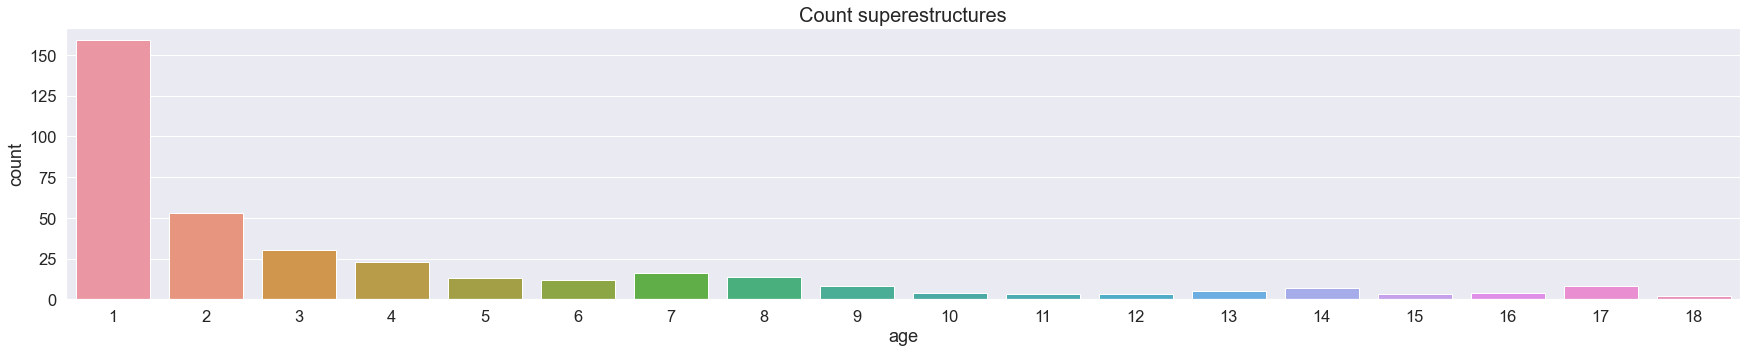

In [45]:
plt.figure(figsize=(30,5))
sns.set(font_scale=1.5)  
sns.countplot(x='age', data=count_superestructures.loc[count_superestructures.age<20])
plt.title("Count superestructures", fontsize=20)
plt.show()

In [49]:
count_superestructures.loc[count_superestructures.age<20].values.sum()

1433

In [16]:
train_values_short.drop(columns='superestructure', inplace=True)
train_values_short = train_values_short.merge(train_values[['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other']], right_index=True, left_index=True)

In [21]:
train_values_short.to_csv("train_values_short_superestructures.csv",index=True)